In [1]:
import math

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Demographic Transition

Define the economy as

$$ L_t = U_t + S_t $$
$$ Y_t^U = Z^\alpha L_t^{1-\alpha}$$
$$ Y_t^S = X_t S_t $$
$$ X_{t+1} = \kappa S_t + X_t$$
$$ {w_t}^{U} = (1-\alpha) U_t^{-\alpha}$$
$$ {w_t}^{S} = X_t $$

where $U_t$ and $S_t$ are population of unskilled and skilled individuals at time $t$ respectively, $Y_t^U$ is the unskilled production function, $ Y_t^S $ is the skilled production function, and $X_t$ is the modern technology at time $t$.

Individuals maxmise a utility function defined as 

$$ {c_t}^{\beta} 
\left[
y_{t+1} n_{t+1} - \frac{1}{2} \left( 
\eta_0 (1 - e_t) + \eta_1 X_{t+1} e_t\right) {n_{t+1}}^2\right]$$

where $c_t$ is the consumption at time $t$ and $e_t \in \{0,1\} $ denotes the individual's choice to invest in the offspring's skills to become skilled, with $e_t = 1$ being the choice to invest in the offspring.

The final derivation of this economy leaves us with a deterministic form for population at time $t+1$:
$$
u_{t+1} = 
\left( 
\frac{\kappa S_t + X_t}
{(1 - \alpha)^{\frac{2}{1+\alpha}} 
\eta_0^{-\frac{1 - \alpha}{1 + \alpha}} 
\eta_1 L_t^{-\frac{2 \alpha}{1 + \alpha}}}
\right)^{-\frac{1 + \alpha}{2 \alpha}}
$$

$$ S_{t+1} = \eta_1 (1-u_{t+1})L_t $$

$$ U_{t+1} = (1 - \alpha)^{\frac{2}{1+\alpha}} \eta_0^{-\frac{1}{1 + \alpha}} 
{u_{t+1}} ^ { \frac{1}{1+\alpha}} L_t^{\frac{1}{1 + \alpha}} $$

where $u_{t+1}$ is the fraction of parents having unskilled children at time $t$.


## Code

The simulation is done deterministically based on the above formulas for $u_{t+1}, S_{t+1}$ and $U_{t+1}$.

Example Usage:

```python
demo_transition = DemographicTransition()
demo_transition.simulate(10)
print(demo_transition.wS)  # print skilled labour wages
print(demo_transition.wU)  # print unskilled labour wages
```

In [7]:
class DemographicTransition:
    def __init__(self,
                 X0=0.001,
                 eta0=1,
                 eta1=90,
                 S0=0,
                 U0=10,
                 alpha=0.5,
                 kappa=2,
                 Z=1):
        
        self.eta0 = eta0
        self.eta1 = eta1
        self.alpha = alpha
        self.kappa = kappa
        self.Z = Z
        
        self.S = [S0]
        self.U = [U0]

        wU_0 = (1 - alpha) * U0**(-alpha)
        self.wS = [X0]  # wages of skilled labour
        self.wU = [wU_0]  # wages of unskilled labour, which is = X0

        self.YS = [S0 * X0]
        self.YU = [Z**alpha * U0**(1-alpha)]
        self.L_steady_state = (1-alpha)**(1/alpha) * eta0**(-1/alpha)


    def check_utility_equality_long_run(self):
        """Returns true if skilled agents will never exist. 
        """

        skilled_utility = (self.eta1 ** (-1)) * self.wS[-1]
        unskilled_utility = (1-self.alpha)**2 * self.eta0**-1 * self.L_steady_state ** (-2*self.alpha)
        #print(f"Skilled:{skilled_utility}, Unskilled:{unskilled_utility}")

        return unskilled_utility > skilled_utility


    def check_utility_equality(self, X_t, L_tp1):
        """Returns true if skilled agents will never exist. 
        """

        skilled_utility = X_t / self.eta1
        unskilled_utility = (1 - self.alpha)**2 * self.eta0**-1 * L_tp1**(-2*self.alpha)

        return unskilled_utility > skilled_utility


    def _u_tplus1(self):  
        #print((-(1 + self.alpha) / (2 * self.alpha)))
        if self.check_utility_equality_long_run():
            return 1 

        u_t_plus_1 = (
        (self.kappa * self.S[-1] + self.wS[-1]) /
        (((1 - self.alpha)**(2 / (1 + self.alpha))) * 
        (self.eta0**(-(1 - self.alpha) / (1 + self.alpha))) * 
        (self.eta1) * 
        ((self.S[-1] + self.U[-1])**(-(2 * self.alpha) / (1 + self.alpha))))
        ) ** (-(1 + self.alpha) / (2 * self.alpha))

        return u_t_plus_1


    def simulate(self, t: int) -> None:

        for _ in range(t):
            L_t = self.S[-1] + self.U[-1]
            
            if self.check_utility_equality(self.wS[-1], L_t):
                u_t_plus_1 = 1
                S_tp1 = 0
                U_tp1 = (((1-self.alpha) * L_t) / (self.eta0)) ** (1/(1+self.alpha))   
            else:    
                u_t_plus_1 = self._u_tplus1()  # Proportion of parents at time t that want unskilled.

                S_tp1 = self.eta1**-1 * (1 - u_t_plus_1) * (L_t)
                U_tp1 = (
                    (1 - self.alpha)**(1/ (1 + self.alpha)) *
                    (self.eta0**(-1 / (1 + self.alpha))) *
                    (u_t_plus_1**(1 / (1 + self.alpha))) *
                    (L_t**(1 / (1 + self.alpha))))
                        
            wS_tp1 = self.kappa * self.S[-1] + self.wS[-1]
            wU_tp1 = (1 - self.alpha) * U_tp1**(-self.alpha)

            YU_tp1 = (self.Z ** self.alpha *  U_tp1 ** (1- self.alpha))
            YS_tp1 = wS_tp1 * S_tp1
            
            self.S.append(S_tp1)
            self.U.append(U_tp1)
            self.wS.append(wS_tp1)
            self.wU.append(wU_tp1)
            self.YS.append(YS_tp1)
            self.YU.append(YU_tp1)


        print(f"{t} time periods simulated. Last time period: t={len(self.S)}")


    def visualise_wage_gap(self, figsize=(12,6), **figure_kwargs):
        plt.figure(figsize=figsize, **figure_kwargs)

        sns.lineplot(self.wS, label='Skilled Wages')
        sns.lineplot(self.wU, label='Unskilled Wages')
        
        plt.title('Wages')
        plt.ylabel("Amount")
        plt.xlabel("T")

        plt.legend()

        plt.show()


    def visualise_income_inequality(self, **figure_kwargs):
        plt.figure(**figure_kwargs)

        sns.lineplot(self.wS, label='Skilled Wages')
        sns.lineplot(self.wU, label='Unskilled Wages')

        plt.title('Income Inequality')
        plt.ylabel("Amount")
        plt.xlabel("T")

        plt.legend()

        plt.show()

    def visualise_pop_growth(self, **figure_kwargs):
        plt.figure(**figure_kwargs)

        sns.lineplot(self.S, label='Skilled Population')
        sns.lineplot(self.U, label='Unskilled Population')

        plt.title('Population Over Time')
        plt.ylabel("Amount")
        plt.xlabel("T")

        plt.legend()

        plt.show()

In [8]:
demo_transition = DemographicTransition(
                 X0=0.3,
                 eta0=0.3,
                 eta1=0.97,
                 S0=0,
                 U0=5,
                 alpha=0.15,
                 kappa=0.4,
)

In [9]:
demo_transition.check_utility_equality_long_run()

False

In [10]:
demo_transition.simulate(50)

50 time periods simulated. Last time period: t=51


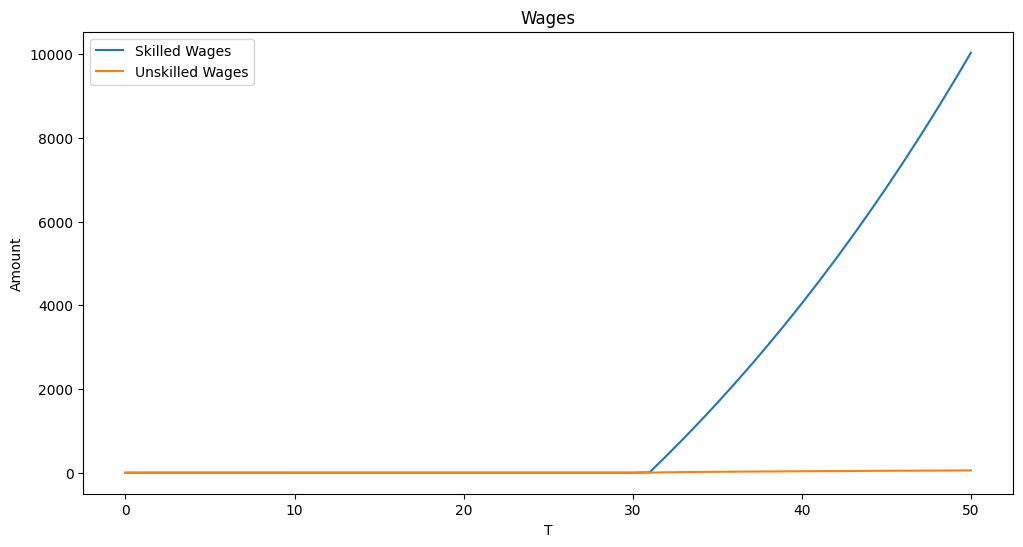

In [11]:
demo_transition.visualise_wage_gap()

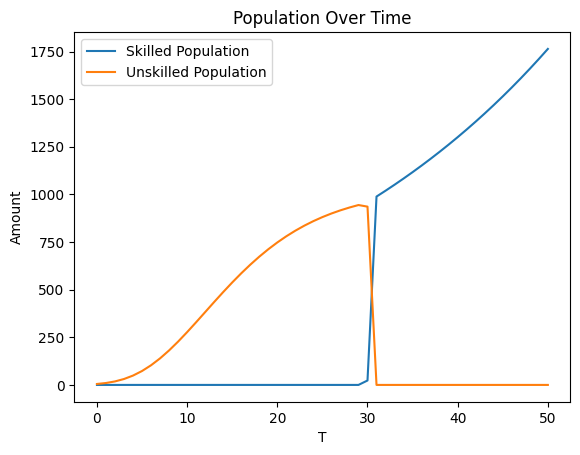

In [12]:
demo_transition.visualise_pop_growth()